# Test Script For Loading Rosetta Radar
Julian Spergel & Isabel Cordero
<br> Created: 04-27-2021
<br> Modified: 05-07-2021

#### Load in required packages

In [1]:
import scipy.io
import os
import pandas as pd
import numpy as np
import xarray as xr
import gcsfs
import json
import matplotlib
import numpy.matlib

#### Load in SIR .mat file
Path is defined in order to show what directory we are working within. This should be a /decimated/mat/ path.
<br> The sirFile variable is defined with the SciPy loadmat(MATFILE)function + matfile:

In [2]:
# Path = '/trunk/icepod/antarctica/20162017/radar/sir/fft/stack04/lines/L870/decimated/mat/';

sirFile = scipy.io.loadmat('RS02_L870_20161129_031207_level1a_SIR_176.mat')

The SciPy function loadmat seems to read .mat files as a "dictionary".
<br> Call the file to read the variables and double check the file type and etc. (not needed in final script likely)

In [ ]:
# sirFile

The following is a pandas function that reads "dictionary" type files.
<br>    This is broken because "not all arrays are the same length/size:

In [ ]:
# pd.DataFrame.from_dict(sirFile)

Read Data variable to determine size/structure (this isn't needed in final script either)

In [ ]:
sirFile['Data']

#### Define variables needed for rendering

In [3]:
Data = sirFile['Data']
Lat = sirFile['Latitude']
Lon = sirFile['Longitude']
Elev = sirFile['Elevation']
Time = sirFile['Time']
Surf = sirFile['Surface']
UTC_time = sirFile['UTC_time']

In [ ]:
Data.shape

Transpose Time variable from column to row:

In [ ]:
Time.transpose()

Fixing dimensions to calculate/clip air above surface of ice:

In [4]:
# Matlab example:
# pixelElev = repmat(Elevation - .5*cAir*Surface,[size(Time,1),1]) - .5*cIce*(repmat(Time,[size(Surface,1),1]) - Surface);
# repmat(a, m, n)
# np.tile(a, (m, n))
cAir = 299792458;   # m/s
cIce = 1.68e8;      # m/s

aboveSurf = Elev - (.5*cAir)*(Surf)
# np.matlib.repmat(Time,[(np.shape(Surf),1),1]) - Surf
aboveSurf.shape
newTime = np.tile(Time,(1,Surf.size))
# belowSurf = (newTime - Surf)*(cIce*0.5)
belowSurf = newTime*(cIce*0.5)
Elevcorr = (aboveSurf - belowSurf)*-1
# Time

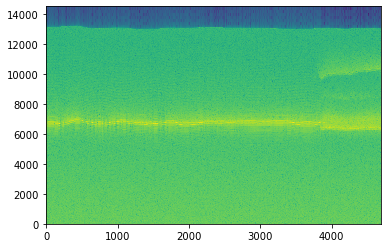

In [13]:
# Elevcorr.shape
matplotlib.pyplot.pcolormesh(da)
# print(np.std(Elevcorr))

Below is defining "da" as the plot:
Not 100% sure of the nuance of all the bits...

In [10]:
da = xr.DataArray(
    data = 20*np.log10(np.abs(Data)),
    dims = ["time","x"],
    coords = dict(
        lon = (["x"], Lon[0]),
        lat = (["x"], Lat[0]),
        time = (["time"],Time.transpose()[0]),
#         elev = (["elev"],Elevcorr.transpose()[0]),
        
    ),
)


Calling "da" shows data array.

In [9]:
da

<xarray.DataArray (time: 14497, x: 4687)>
array([[  11.99983235,   11.10372469,    9.91507805, ...,    6.40627414,
          14.50836097,    6.91593304],
       [  10.82987613,   10.75828119,    8.66961873, ...,    9.0459488 ,
          15.71258667,    9.98670146],
       [  10.839479  ,   10.98579845,   10.11085352, ...,   11.63670135,
          15.96190312,   12.76525663],
       ...,
       [-130.24742321, -128.99205728, -130.28186781, ..., -140.80531617,
        -143.79947877, -152.16940392],
       [-145.76667609, -139.95464771, -135.75244888, ..., -155.71564204,
        -160.77935115, -153.16342926],
       [-130.25176707, -131.02304867, -135.74698337, ..., -141.96582245,
        -142.96900119, -147.19296441]])
Coordinates:
    lon      (x) float64 -175.9 -175.9 -175.9 -175.9 ... -177.1 -177.1 -177.1
    lat      (x) float64 -77.95 -77.95 -77.95 -77.95 ... -77.97 -77.97 -77.97
  * time     (time) float64 1.191e-06 1.191e-06 1.192e-06 ... 1.04e-05 1.04e-05
Dimensions without coordinates: x

Plots "da" radargram.
<br> vmin and vmax change colors/resolution of image.

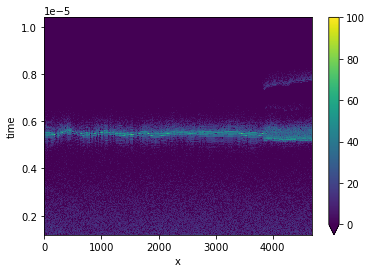

In [7]:
# da.plot(x=time)
da.plot(vmin = 0, vmax = 100)
# da.plot()

### Push to google bucket
Doesn't work yet...

In [ ]:
gcs = gcsfs.GCSFileSystem()
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
#EXPORT THE DATA TO THE  GOOGLE BUCKET
mapper = gcs.get_mapper('gs://ldeo-glaciology/Isabel/test1/') #choose where to put it
da.to_zarr(mapper, mode='w');

In [ ]:
#EXPORT A DATASET 
measures_exported = measures #a dataset that is ready to be  exported
gcs = gcsfs.GCSFileSystem()
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
#EXPORT THE DATA TO THE  GOOGLE BUCKET
mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/') #choose where to put it
measures.to_zarr(mapper, mode='w');
#IMPORT THE FILES TOU JUST SENT TO THE BUCKET
mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
measures_IMPORTED = xr.open_zarr(mapper,overwrite_encoded_chunks=True)

# Working section: Removing air above surface to plot entire ice shelf section
Below are working sections in order to debug the above "final" code.

In [ ]:
# Matlab example:
# pixelElev = repmat(Elevation - .5*cAir*Surface,[size(Time,1),1]) - .5*cIce*(repmat(Time,[size(Surface,1),1]) - Surface);
# repmat(a, m, n)
# np.tile(a, (m, n))
cAir = 299792458;   # m/s
cIce = 1.68e8;      # m/s

aboveSurf = Elev - (.5*cAir)*(Surf)
# np.matlib.repmat(Time,[(np.shape(Surf),1),1]) - Surf
aboveSurf.shape
newTime = np.tile(Time,(1,Surf.size))
belowSurf = (newTime - Surf)*(cIce*0.5)
Elevcorr = aboveSurf - belowSurf
newElev = Elevcorr[:,0]
newTime.shape
# newElev = Elevcorr{1}
# Time.transpose() - np.reshape(Surf,Time.shape)
# Time - (np.pad(Surf,Time.shape,mode='empty', **0))
# (array, pad_width, mode='constant', **kwargs)
# newElev = [Elev.transpose(((Elev - .5*cAir*Surf),Surf)) - .5*cIce*(Time - Surf.transpose((1,Time)))]

In [ ]:
# adjustSurf = Surf.transpose()
# Time.transpose()
# adjustTime = Time.squeeze(4687,1)
# np.reshape(Surf,(1,4687))
# np.pad(Surf,(,4687),)
time2 = Time.transpose()
surf2 = np.matlib.repmat(Surf,np.shape(time2),1)
# surf2.shape

# np.matlib.repmat(Surf,Time,np.pad(Surf,(0,4687),'constant'))